In [1]:
import hydra
from omegaconf import OmegaConf
from glob import  glob
# from rosa import  predict
from rosa.data import create_io_paths, RosaDataModule
from rosa.modeling.modules import RosaLightningModule
from pytorch_lightning import Trainer


BASE_DIR = "/Users/nsofroniew/Documents/data/rosa/outputs/2023-02-13/11-35-55"
config_dir = BASE_DIR + "/.hydra"

with hydra.initialize_config_dir(config_dir=config_dir):
    config = hydra.compose(config_name="config", overrides=OmegaConf.load(config_dir + "/overrides.yaml"))

    chkpts = BASE_DIR + "/checkpoints/*.ckpt"
    chkpt = glob(chkpts)[1]

    _, output_path = create_io_paths(config.paths)

    # Create Data Module
    rdm = RosaDataModule(
        output_path,
        config=config.data_module,
    )
    rdm.setup()

    # Load model from checkpoint
    rlm = RosaLightningModule.load_from_checkpoint(
        chkpt,
        in_dim=rdm.len_input,
        out_dim=rdm.len_target,
        config=config.module,
    )
    print(rlm)

    # trainer = Trainer()
    # predictions = trainer.predict(rlm, rdm)
    # rdm.predict_dataset.predict(predictions)
    # adata = rdm.predict_dataset.adata
    # adata = predict(config, chkpt)

# display(adata)

Global seed set to 0
/Users/nsofroniew/opt/anaconda3/envs/multiomics/lib/python3.9/site-packages/pytorch_lightning/utilities/warnings.py:53: LightningDeprecationWarning: pytorch_lightning.utilities.warnings.rank_zero_deprecation has been deprecated in v1.6 and will be removed in v1.8. Use the equivalent function from the pytorch_lightning.utilities.rank_zero module instead.
  new_rank_zero_deprecation(
/Users/nsofroniew/opt/anaconda3/envs/multiomics/lib/python3.9/site-packages/pytorch_lightning/utilities/warnings.py:58: LightningDeprecationWarning: The `pytorch_lightning.loggers.base.rank_zero_experiment` is deprecated in v1.7 and will be removed in v1.9. Please use `pytorch_lightning.loggers.logger.rank_zero_experiment` instead.
  return new_rank_zero_deprecation(*args, **kwargs)
/var/folders/6n/b_zkz2ns3_l02s3g4lnlklxr0000gq/T/ipykernel_55110/4235644688.py:13: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume

RosaLightningModule(
  (model): RosaJointModel(
    (main): Sequential(
      (dual_embed): ParallelEmbed(
        (models): ModuleList(
          (0): Sequential(
            (layer_norm_0): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
            (input_embed_0): Identity()
          )
          (1): Sequential(
            (layer_norm_1): LayerNorm((3072,), eps=1e-05, elementwise_affine=True)
            (input_embed_1): InputEmbed(
              (model): Sequential(
                (projection): Linear(in_features=3072, out_features=256, bias=True)
                (layer_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
                (dropout): Dropout(p=0.5, inplace=False)
              )
            )
          )
        )
      )
      (join_embeds): DotEmbeds()
      (feed_forward): Identity()
      (dropout): Dropout(p=0, inplace=False)
      (expression_head): ProjectionExpressionHead(
        (model): Sequential(
          (projection): Identity()
     

In [2]:
config.data_module

{'data': {'expression_layer': None, 'var_input': 'embedding', 'obs_input': 'embedding', 'expression_transform': None, 'n_var_sample': 10000}, 'batch_size': 32, 'num_workers': 0}

In [3]:
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from captum.attr import IntegratedGradients, InputXGradient

In [4]:
adata = rdm.predict_dataset.adata
test_obs = np.logical_not(adata.obs['train'])
test_var = np.logical_not(adata.var['train'])

In [5]:
import torch.nn as nn

class FullModel(nn.Module):
    def __init__(self, rlm):
        super(FullModel, self).__init__()
        self.model = rlm.model

    def forward(self, x1, x2):
        return self.model((x1, x2))

In [6]:
model = FullModel(rlm)
ixg = InputXGradient(model)

In [7]:
x, y = next(iter(rdm.predict_dataloader(batch_size=1)))

In [8]:
model(*x).shape

torch.Size([1, 19431])

In [9]:
y.shape

torch.Size([1, 19431])

In [10]:
x_r = tuple(x_ind.reshape(-1, x_ind.shape[-1]).requires_grad_() for x_ind in x)

In [11]:
x_r[1].shape

torch.Size([19431, 3072])

In [12]:
attribution_r = ixg.attribute(x_r)

In [13]:

attribution = tuple(a.reshape(x[0].shape[0], x[0].shape[1], -1) for a in attribution_r)

In [14]:
attribution[0].shape

torch.Size([1, 19431, 256])

In [15]:
attribution[1].shape

torch.Size([1, 19431, 3072])

In [16]:
attr = next(iter(rlm.explain_iter(rdm.predict_dataloader(batch_size=1), ixg)))

In [17]:
attr[0].shape

torch.Size([1, 19431, 256])

In [22]:
import zarr

# results_shape = tuple((len(rdm.predict_dataset), rdm.len_target, r) for r in rdm.len_input) # rdm.len_target
results_shape = tuple(rdm.predict_dataset.adata.shape + (r,) for r in rdm.len_input) # rdm.len_target
# results_shape = rdm.predict_dataset.adata.shape + (rdm.len_input,)
z = tuple(zarr.open(f'data/joint_attribution{i}.zarr', mode='w', shape=r, chunks=(1, None, None), dtype=np.float32) for i, r in enumerate(results_shape))

ind = 0
dl = rdm.predict_dataloader(batch_size=1)
for attribution in tqdm(iter(rlm.explain_iter(dl, ixg)), total=len(dl)):
    for i, a in enumerate(attribution):
        z[i][ind:ind+len(a), :, :] = a.detach().numpy() # for joint
    ind += len(a)

369it [03:38,  1.69it/s]


In [42]:
import dask.array as da

z = tuple(da.from_zarr(f'data/joint_attribution{i}.zarr') for i in range(2))


In [40]:
z[0]

dask.array<from-zarr, shape=(369, 19431, 256), dtype=float32, chunksize=(1, 19431, 256), chunktype=numpy.ndarray>

In [41]:
z[1]

dask.array<from-zarr, shape=(369, 19431, 3072), dtype=float32, chunksize=(1, 19431, 3072), chunktype=numpy.ndarray>

In [27]:
np.mean(np.abs(z[1]), axis=(0, 1))

dask.array<mean_agg-aggregate, shape=(3072,), dtype=float32, chunksize=(3072,), chunktype=numpy.ndarray>

In [28]:
z_avg = tuple(np.asarray(da.abs(z_i).mean(axis=(0, 1))) for z_i in z)

In [29]:
z[1].shape

(369, 19431, 3072)

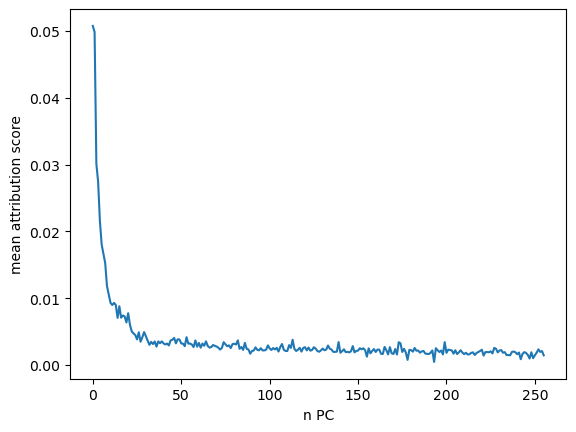

In [30]:
plt.plot(np.arange(len(z_avg[0])), z_avg[0]);
plt.xlabel('n PC');
plt.ylabel('mean attribution score');

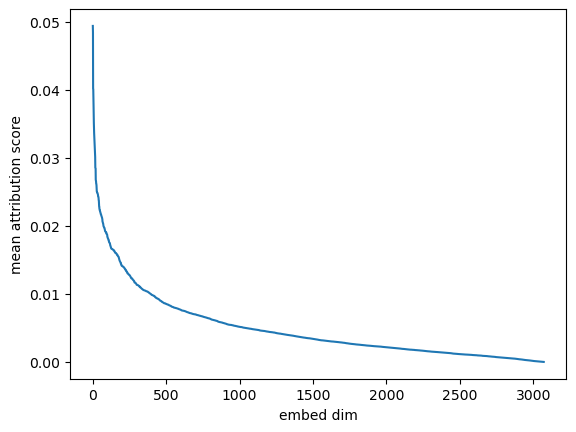

In [31]:
plt.plot(np.arange(len(z_avg[1])), np.sort(z_avg[1])[::-1]);
plt.xlabel('embed dim');
plt.ylabel('mean attribution score');

In [43]:
indices = np.argsort(z_avg[1])[::-1]
z = (z[0], z[1][:, :, indices])

In [44]:
z = tuple(np.asarray(z_ind[:, :, :50]) for z_ind in z)

In [45]:
C = np.zeros((z[0].shape[2], z[1].shape[2]))

for t in tqdm(range(z[0].shape[2])):
    for s in tqdm(range(z[1].shape[2])):
        C[t, s] = np.corrcoef(z[0][test_obs][:, test_var, t].flatten(), z[1][test_obs][:, test_var, s].flatten())[0, 1]

100%|██████████| 50/50 [03:48<00:00,  4.57s/it]


In [46]:
import seaborn as sns

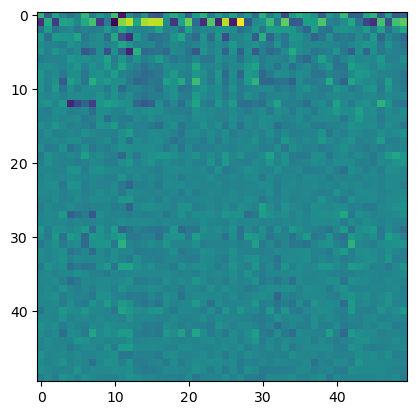

In [47]:
plt.imshow(C)

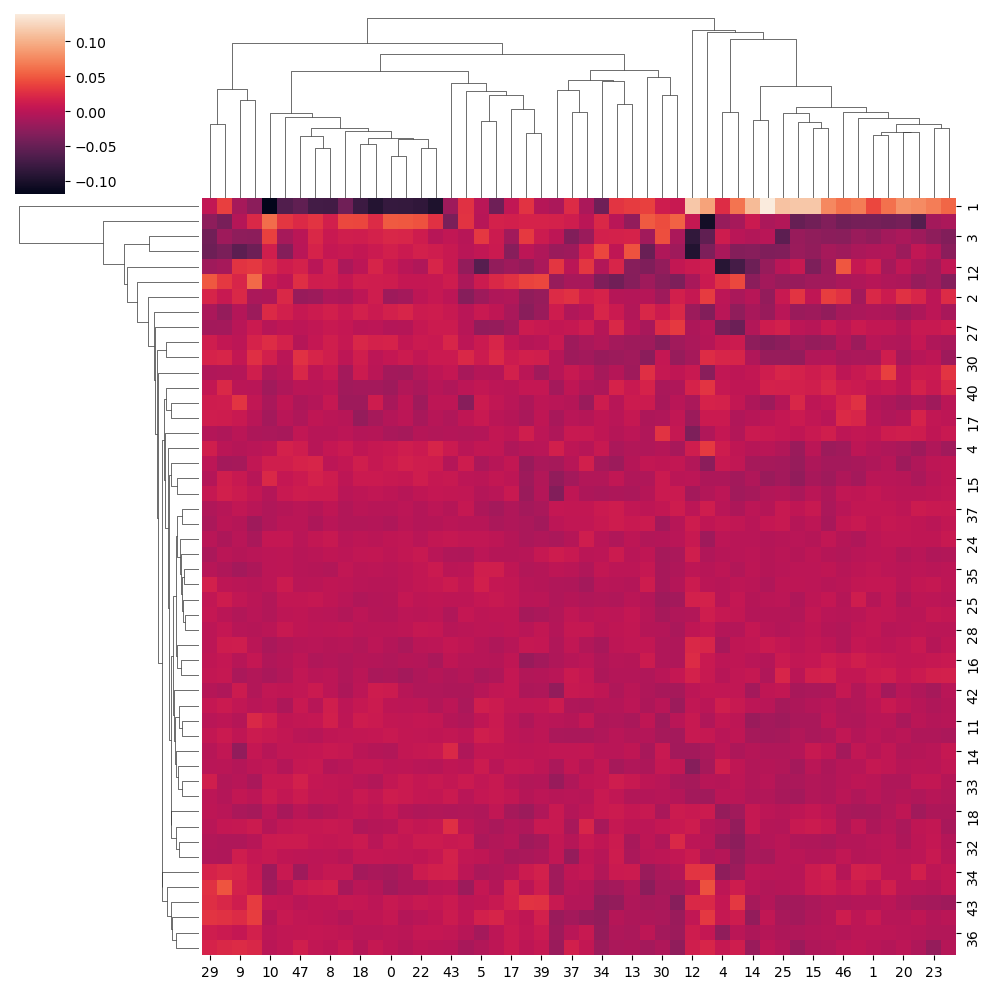

In [48]:
sns.clustermap(C)

## Full model

In [13]:
from sklearn.decomposition import PCA


train_cells = adata.obs['train']
train_genes = adata.var['train']
adata_split = adata[train_cells, train_genes]

# fit pca on training data
pca = PCA()
pca.fit(adata_split.X)

# compute scores for all cells
pca_expression = pca.transform(adata[:, train_genes].X)

# # add cell embeddings to obsm
# n_pcs = config.pcs
# n_pcs = min(n_pcs, pca_expression.shape[1] - 1)
# adata.obsm["embedding"] = pca_expression[:, :n_pcs]
# adata.uns["obs_embedding_pca"] = {
#     "explained_variance": np.cumsum(pca.explained_variance_ratio_)[n_pcs]
# }

In [14]:
from enformer_pytorch import Enformer


MODEL_PT = "EleutherAI/enformer-official-rough"
SEQ_EMBED_DIM = 896
EMBED_DIM = 3072
TSS = int(SEQ_EMBED_DIM // 2)

In [15]:
import torch.nn as nn
import torch

class FullJointModel(nn.Module):
    def __init__(self, rlm, pca, indices=None):
        super(FullJointModel, self).__init__()
        self.input_mean = torch.from_numpy(pca.mean_)
        self.input_weights = torch.from_numpy(pca.components_[:256])
        self.enformer = Enformer.from_pretrained(MODEL_PT, output_heads=dict(), use_checkpointing=False)
        self.tss = TSS
        self.model = rlm.model
        self.indices = indices

    def forward(self, x1, x2):
        if self.indices is not None:
            x1 = x1[:, self.indices]
        x1 = x1 - self.input_mean
        x1 = torch.einsum('ij, kj -> ik', x1, self.input_weights)
        _, x2 = self.enformer(x2, return_embeddings=True)
        x2 = x2[:, self.tss]
        return self.model((x1, x2))

In [16]:
BASE_PT = "/Users/nsofroniew/Documents/data/multiomics/enformer"
FASTA_PT = BASE_PT + "/Homo_sapiens.GRCh38.dna.toplevel.fa"

config.data_module.data.var_input = FASTA_PT
config.data_module.data.obs_input = 'X'

In [17]:
# Create Data Module
rdm = RosaDataModule(
    output_path,
    config=config.data_module,
)
rdm.setup()

In [26]:
import zarr

test_indices = np.where(np.logical_not(rdm.test_dataset.adata.var['train']))[0]
train_indices = np.where(rdm.test_dataset.adata.var['train'])[0]
results_shape = tuple((len(rdm.test_dataset), len(test_indices), r,) for r in rdm.len_input) # rdm.len_target
z = tuple(zarr.open(f'data/joint_attribution{i}.zarr', mode='w', shape=r, chunks=(1, None, None), dtype=np.float32) for i, r in enumerate(results_shape))

# results_shape = (len(rdm.test_dataset), len(test_indices), len(train_indices))
z = tuple(zarr.open(f'data/joint_attribution_full{i}.zarr', mode='w', shape=r, chunks=(1, None, None), dtype=np.float32) for i, r in enumerate(results_shape))
dl = rdm.test_dataloader(batch_size=1)

model = FullJointModel(rlm, pca, indices=train_indices)
ixg = InputXGradient(model)


Some weights of the model checkpoint at EleutherAI/enformer-official-rough were not used when initializing Enformer: ['_heads.human.0.weight', '_heads.mouse.0.bias', '_heads.mouse.0.weight', '_heads.human.0.bias']
- This IS expected if you are initializing Enformer from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing Enformer from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [27]:
z

(<zarr.core.Array (97, 5792, 19431) float32>,
 <zarr.core.Array (97, 5792, 196608) float32>)

In [29]:
z[1].nbytes / 1e9

441.836371968

In [30]:
ind = 0
for attribution in tqdm(iter(rlm.explain_iter(dl, ixg)), total=len(dl)):
    for i, a in enumerate(attribution):
        z[i][ind:ind+len(a), :, :] = a.detach().numpy() # for joint
    ind += len(a)

  0%|          | 0/97 [00:00<?, ?it/s]

In [ ]:
from rosa.utils import score_predictions, plot_expression_and_correlation, plot_marker_gene_heatmap


adata_test, results = score_predictions(adata)

In [ ]:
plot_expression_and_correlation(adata_test, results)

In [ ]:
import numpy as np


marker_genes = adata_test.var[adata_test.var['highly_variable']]['feature_name'].values
np.random.seed(42)
marker_genes = np.random.choice(marker_genes, 50)

plot_marker_gene_heatmap(adata_test, marker_genes)

In [ ]:
marker_genes_dict = adata_test.obs.set_index('label').to_dict()['marker_feature_name']
plot_marker_gene_heatmap(adata_test, marker_genes_dict)